# **Лабораторная работа № 2.**
### по курсу «Нейроинформатика»
## **Тема: Линейная нейронная сеть. Правило обучения Уидроу-Хоффа**



> Студент: Овечкин В.А.

> Группа: М8О-408Б-18

> Преподаватель: Аносова Н.П.

> Оценка:


## **Цель работы**: 
Исследование свойств линейной нейронной сети и алгоритмов ее
обучения, применение сети в задачах аппроксимации и фильтрации.

## **Постановка задачи:**

1.    Использовать линейную нейронную сеть с задержками для аппроксимации функции. В
качестве метода обучения использовать адаптацию.
2.   Использовать линейную нейронную сеть с задержками для аппроксимации функции и
выполнения многошагового прогноза.

3.   Использовать линейную нейронную сеть в качестве адаптивного фильтра для подавления
помех. Для настройки весовых коэффициентов использовать метод наименьших квадратов.


## **Вариант** :
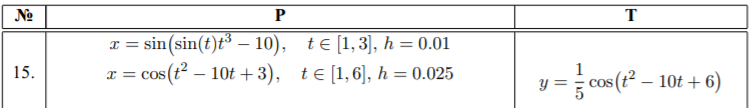



###Теория
Линейные нейросети отличаются от персептронов из первой лабораторной работы тем, что их выходные данные могут отличаться от "0" и "1".
Для решения поставленной задачи воспользуемся фильтратором, состоящим из Temporal Difference Learning- временным разностнм обучением, которое генерирует на основе предшествующих значений выходной вектор данной длины и линейного слоя, который в качестве активационной функции имеет линейную функцию аналогичную алгоритму линейной регрессии.

Фильтратор имеет вид:

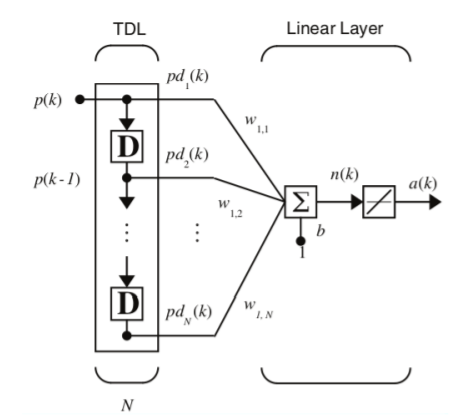

Для реализации линейного слоя будем представлять веса и смещение как матрирцу (n+1)*m, где n - число входов, а m - число выходов. Функция net = $∑_{i=0}^n w_i*x_i + b$, а изменение ошибки будет вычисляться при помощи метрики MSE = $(∑_{i=0}^N (t_i - a_i)^2) / N$

Для обучения воспользуемся правилом Уидроу-Хоффа(дельта-правило), практически идентичное классическому стохастическому градиентному спуску, но выбор объекта из выборки для корректирования значений беретя в определенной последовательности вместо случайной. Идея в том, чтобы корректировать веса в сторону наискорейшего убывания функции ошибки(т.е. в напр. антиградиента ошибки)

# Листинг кода

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [ ]:
def x1_t(t):
    return np.cos(np.sin(t) * t ** 3 - 10)

def x2_t(t):
    return np.sin(t ** 2 - 10 * t + 3)

def y_t(t):
    return np.cos(t ** 2 - 10 * t + 6) / 5

h1 = 0.01
h2 = 0.025

t_lim1 = (1, 3)
t_lim2 = (1, 6)

In [ ]:
class LinearLayer:
    def __init__(self, steps = 50, lr = 0.0001, stop_err=0.0):
        self.steps = steps
        self.w = None
        self.rate = lr
        self.stop_err = stop_err
    
    def fit(self, X, y):
        # add column for bias and transpose data for comfort operations:
        X_t = np.append(X, np.ones((X.shape[0], 1)), axis = 1)
        y_t = np.array(y)
        
        #initial weights:
        if self.w is None:
            self.w = np.random.random((X_t.shape[1], y_t.shape[1]))
        
        # main loop:
        for step in tqdm(range(self.steps)):
            for i in range(X_t.shape[0]):
                e = y_t[i] - X_t[i].dot(self.w) # calc error
                # change weights:
                self.w += self.rate * \
                    X_t[i].reshape(
                        X_t.shape[1], 1
                    ).dot(
                        e.reshape(1, y_t.shape[1])
                    )
            mse = ((y_t - X_t.dot(self.w))**2).mean()
            if mse < self.stop_err:
                break
                
        return self # return trained model
    
    def set_steps(self, steps):
        self.steps = steps
        
    def set_learning_rate(self, rate):
        self.rate = rate
    
    # Predict answers
    def predict(self, X):
        X_t = np.append(X, np.ones((X.shape[0], 1)), axis = 1)
        return X_t.dot(self.w)
    
    
    def display(self):
        ans = "Input(n," + str(self.w.shape[0] - 1) + ")  -->  "
        ans += "Linear_Layer(" + str(self.w.shape[1]) + ")  -->  "
        ans += "Output(n, " + str(self.w.shape[1]) + ") --> "
        return ans
    
    def weights(self):
        return self.w[:-1]
    
    def bias(self):
        return self.w[-1]
        
    
    # RMSE
    def score(self, X, y):
        X_t = np.append(X, np.ones((X.shape[0], 1)), axis = 1)
        y_t = np.array(y)
        return ((y_t - X_t.dot(self.w))**2).mean()**0.5
    
    def __str__(self):
        return "Linear Layer"
    
    def __repr__(self):
        return self.__str__()

Добавлено наличие текущего состояния для генерации нового вектора

In [ ]:
class TDL:
    def __init__(self, D = 1, pad_zeros=True):
        self.depth = D
        self.padding = pad_zeros
        self.queue = np.zeros(D)
        
    def fit(self, X, Y = None):
        # initial train data like in self.predict method
        if self.padding:
            in_arr = np.append(np.zeros(self.depth - 1), X)
            result = np.zeros((len(X) - 1, self.depth))
            if Y is None:
                Y = X[-len(X) + 1:]
            else:
                Y = Y[-len(X) + 1:]
        else:
            if len(X) < self.depth:
                return None
            in_arr = np.array(X)
            result = np.zeros((len(X) - self.depth, self.depth))
            if Y is None:
                Y = X[-len(X) + self.depth:]
            else:
                Y = Y[-len(X) + self.depth:]
        
        for i in range(in_arr.shape[0] - self.depth):
            result[i] = in_arr[i:i + self.depth]
            
        return result, Y
    
    def tdl_init(self, values):
        if values.shape[0] != self.depth - 1:
            raise ValueError("You should give " + str(self.depth - 1) + " values to init")
        self.queue = np.append(np.zeros(1), np.array(values))
        
        
    def tdl_init_zeros(self):
        self.queue = np.zeros(self.depth)
        
    
    def predict(self, X):
        # init delay line and alloc memory
        in_arr = np.append(self.queue[1:], X)
        result = np.zeros((len(X), self.depth))
        
        # fill memory buffer by values of line
        for i in range(in_arr.shape[0] - self.depth + 1):
            result[i] = in_arr[i:i + self.depth]
        # update queue
        self.queue = in_arr[-self.depth:]
        return result
        
    
    def display(self):
        ans = "TDL(" + str(self.depth) + ") --> "
        return ans
    
    def __str__(self):
        return "TDL"
    
    def __repr__(self):
        return self.__str__()

In [ ]:
class Filtrator:
    def __init__(self, D = 1, pad_zeros = False, steps = 50, l_r=0.001, stop_err=0.0):
        self.tdl = TDL(D, pad_zeros)
        self.linlr = LinearLayer(steps, l_r, stop_err)
        self.tld_initialized = pad_zeros
        self.last_predict = None
        
    def fit(self, X, Y = None):
        X1, Y1 = self.tdl.fit(X, Y)
        Y1 = np.array(Y1).reshape(len(Y1), 1)
        self.linlr.fit(X1, Y1)
        return self
    
    def tdl_init(self, values):
        self.tdl.tdl_init(values)
        self.tld_initialized = True
        
    def tdl_init_zeros(self):
        self.tdl.tdl_init_zeros()
        self.tld_initialized = True
        
    def predict(self, x):
        if not self.tld_initialized:
            raise ValueError("You should init input before predict")
        ans = self.linlr.predict(self.tdl.predict(x)).ravel()
        self.last_predict = ans[-1]
        return ans
            
    def display(self):
        return self.tdl.display() + self.linlr.display()
    
    @staticmethod
    def score_value(Y_t, Y_p):
        return ((Y_t - Y_p)**2).mean()**0.5
        
    def gen_values(self, num, inpt = None):
        if inpt is not None:
            self.last_predict = inpt
        if self.last_predict is None:
            raise ValueError("Last predict isn't known. " + 
                             "Set last predicted value or make prediction.")
        for i in range(num):
            yield self.predict(np.array([self.last_predict]))[0]
    
    def __str__(self):
        return "Adaptive Filtrator"
    
    def __repr__(self):
        return self.__str__()

Получим входную последовательность по заданному интервалу и шагу

In [ ]:
T = np.append(np.arange(*t_lim1, h1), t_lim1[1])
X = x1_t(T)

print("Set beginning:", X[:5], "\n" + "Set end:", X[-5:])

Set beginning: [-0.96476464 -0.9561398  -0.9463524  -0.93534199 -0.92304834] 
Set end: [0.5679119  0.7272056  0.85723482 0.94926974 0.99563901]


Инициализация модели фильтратора.\
Глубина задержек D = 5;\
Используем задержки, а не погружение временного ряда, т.е. не заполняем входное множество нулями;\
Скорость обучения линейного слоя = 0.01;\
Количество шагов для обучения линейного слоя = 50.\
Обучим модель для одношагового прогноза и посмотрим архитектуру полученной сети.

In [ ]:
D = 5
steps = 50
learn_rate = 0.01

model = Filtrator(D, False, steps, learn_rate).fit(X)
print(model.display())

100%|██████████| 50/50 [00:00<00:00, 819.19it/s]

TDL(5) --> Input(n,5)  -->  Linear_Layer(1)  -->  Output(n, 1) --> 


Разделим множество на составляющие,

1. которыми будем инициализировать модель (D)
2. которыми будем предсказывать следующий вход
3. действительный вход модели





In [ ]:
X_init = X[:D - 1]
X_test = X[D - 1:-1]

X_ans = X[D:]

Проинциализируем модель первыми D значениями множества

In [ ]:
model.tdl_init(X_init)

Сделаем одношаговое предсказание на обучающих данных с помощью обученного фильтра

In [ ]:
X_pred = model.predict(X_test)

Посмотрим на результат предсказания на первом входном множестве

RMSE = 0.02187986114974215


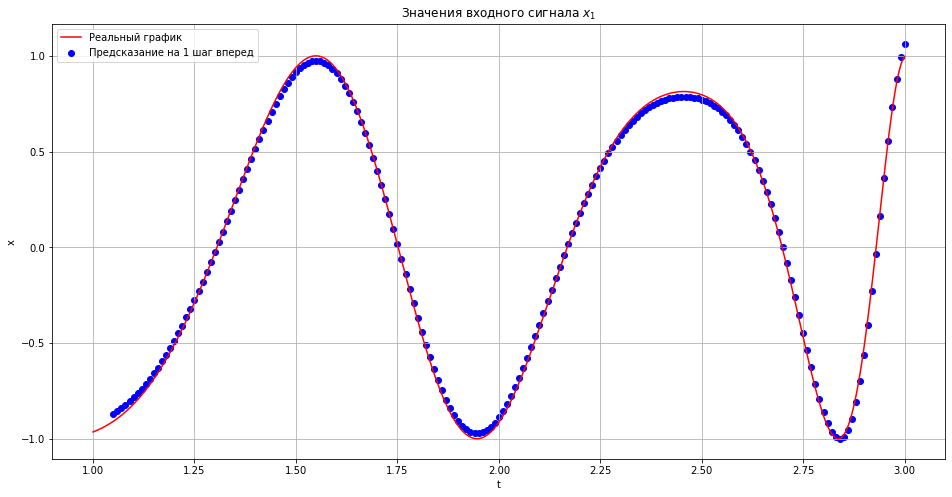

In [ ]:
t = np.arange(*t_lim1, 0.0001)
x = x1_t(t)
plt.figure(figsize=(16, 8))
plt.plot(t, x, color = "red", label="Реальный график")

plt.scatter(T[D:], X_pred, color="blue", label="Предсказание на 1 шаг вперед")
plt.title("Значения входного сигнала $x_1$")
plt.xlabel("t")
plt.ylabel("x")
plt.grid()
plt.legend()

print("RMSE =", model.score_value(X_ans, X_pred))

Получим входную последовательность по заданному интервалу и шагу

In [ ]:
T = np.append(np.arange(*t_lim1, h1), t_lim1[1])
X = x1_t(T)

print("Set beginning:", X[:5], "\n" + "Set end:", X[-5:])

Set beginning: [-0.96476464 -0.9561398  -0.9463524  -0.93534199 -0.92304834] 
Set end: [0.5679119  0.7272056  0.85723482 0.94926974 0.99563901]


Инициализация модели фильтратора.\
Глубина задержек D = 3;\
Используем задержки, а не погружение временного ряда, т.е. не заполняем входное множество нулями;\
Скорость обучения линейного слоя = 0.005;
Количество шагов для обучения линейного слоя = 600;\
Ошибка для критерия останова алгоритма обучения = $10^{-6}$

Обучим модель для одношагового прогноза и посмотрим архитектуру полученной сети.

In [ ]:
D = 3
steps = 600
learn_rate = 0.005
stop_val = 10e-6

model = Filtrator(D, False, steps, learn_rate, stop_val).fit(X)
print(model.display())

100%|██████████| 600/600 [00:00<00:00, 825.43it/s]

TDL(3) --> Input(n,3)  -->  Linear_Layer(1)  -->  Output(n, 1) --> 


Разделим множество на составляющие,

1. которыми будем инициализировать модель (D)
2. которыми будем предсказывать следующий вход
3. действительный вход модели

In [ ]:
X_init = X[:D - 1]
X_test = X[D - 1:-1]

X_ans = X[D:]

Проинциализируем модель первыми D значениями множества

In [ ]:
model.tdl_init(X_init)

Сделаем одношаговое предсказание на обучающих данных с помощью обученного фильтра

In [ ]:
X_pred = model.predict(X_test)

Посмотрим на результат предсказания на первом обучающем множестве

RMSE = 0.009445146574708126


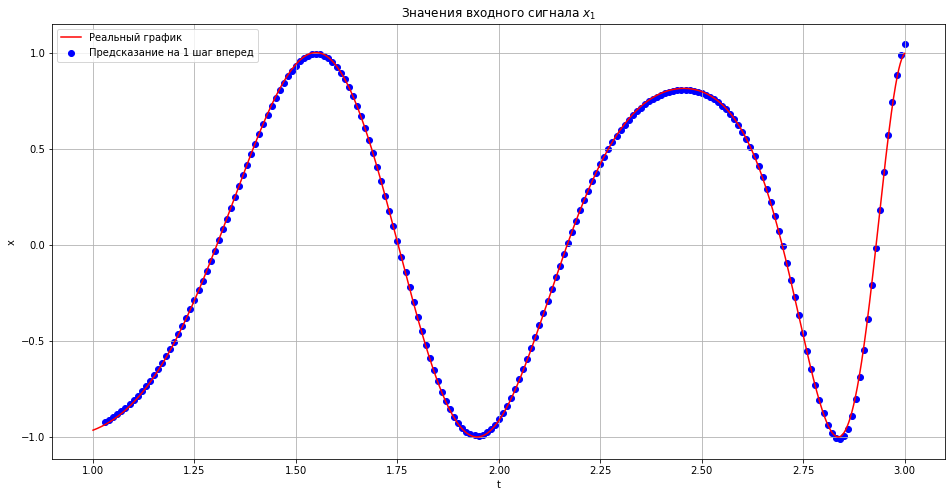

In [ ]:
t = np.arange(*t_lim1, 0.0001)
x = x1_t(t)
plt.figure(figsize=(16, 8))
plt.plot(t, x, color = "red", label="Реальный график")

plt.scatter(T[D:], X_pred, color="blue", label="Предсказание на 1 шаг вперед")
plt.title("Значения входного сигнала $x_1$")
plt.xlabel("t")
plt.ylabel("x")
plt.grid()
plt.legend()

print("RMSE =", model.score_value(X_ans, X_pred))

Посмотрим на предсказание за пределы обучающего множества на $K=10$ шагов вперед.

In [ ]:
K = 10

X_pred = np.array(list(model.gen_values(K)))

Аргумент T и реальное значение для предсказанных значений

In [ ]:
T_pred = []
for i in range(1, K + 1):
    T_pred.append(t_lim1[1] + i*h1)
    
T_pred = np.array(T_pred)
X_ans = x1_t(T_pred)

RMSE = 1.2514596065940229


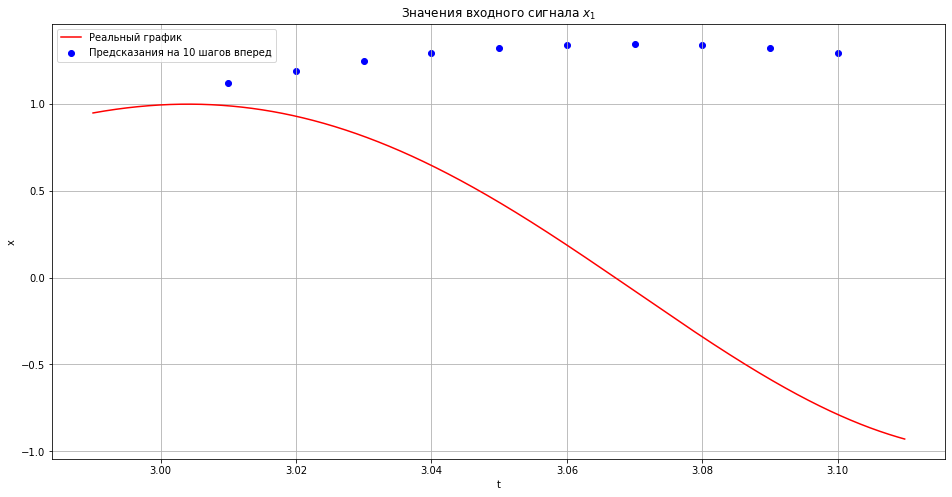

In [ ]:
t = np.arange(t_lim1[1] - h1, t_lim1[1] + h1*11, 0.0001)
x = x1_t(t)
plt.figure(figsize=(16, 8))
plt.plot(t, x, color = "red", label="Реальный график")

plt.scatter(T_pred, X_pred, color="blue", label="Предсказания на 10 шагов вперед")
plt.title("Значения входного сигнала $x_1$")
plt.xlabel("t")
plt.ylabel("x")
plt.grid()
plt.legend()

print("RMSE =", model.score_value(X_ans, X_pred))

Task 3

Получим входную последовательность по заданному интервалу и шагу

In [ ]:
T = np.append(np.arange(*t_lim2, h2), t_lim2[1])
X = x2_t(T)
Y = y_t(T)

print("Set beginning:", X[:5], "\n" + "Set end:", X[-5:])

Set beginning: [ 0.2794155   0.08371223 -0.11406588 -0.3061914  -0.48539482] 
Set end: [-0.71815584 -0.74914711 -0.77936303 -0.80860286 -0.83665564]


Инициализация модели фильтратора.\
Глубина задержек D = 4;\
Используем погружение временного ряда, а не задержки, т.е. заполняем входное множество нулями;\
Скорость обучения линейного слоя = 0.0025;\
 Количество шагов для обучения линейного слоя = 500;\
Ошибка для критерия останова алгоритма обучения =  $10^{−6}$

Обучим модель для одношагового прогноза и посмотрим архитектуру полученной сети.

Параметром обучения станет набор входных данных для того, чтобы предсказывать следующие значение выходного сигнала, а не входного.

In [ ]:
D = 4
steps = 500
learn_rate = 0.0025
stop_val = 10e-6

model = Filtrator(D, True, steps, learn_rate, stop_val).fit(X, Y)
print(model.display())

100%|██████████| 500/500 [00:00<00:00, 813.60it/s]

TDL(4) --> Input(n,4)  -->  Linear_Layer(1)  -->  Output(n, 1) --> 


Разделим множество на составляющие,

1. которыми будем инициализировать модель (D)
2. которыми будем предсказывать следующий вход
3. действительный вход модели

In [ ]:
X_test = X[:-1]

X_ans = X[1:]
Y_ans = Y[1:]

Проинициализируем модель нулевыми значениями

In [ ]:
model.tdl_init_zeros()

Сделаем одношаговое предсказание источника шума с помощью обученного фильтра на обучающем множестве

In [ ]:
Y_pred = model.predict(X_test)

RMSE = 0.10206029555856806


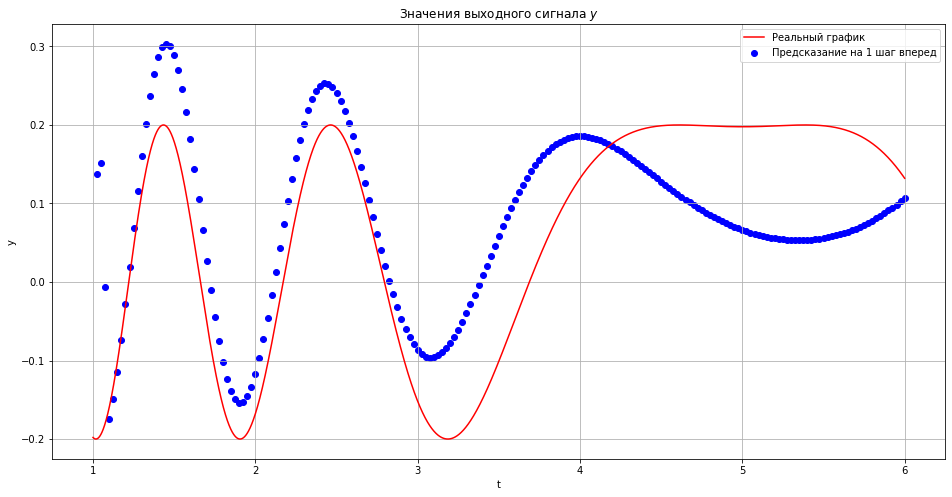

In [ ]:
t = np.arange(*t_lim2, 0.0001)
x = y_t(t)
plt.figure(figsize=(16, 8))
plt.plot(t, x, color = "red", label="Реальный график")

plt.scatter(T[1:], Y_pred, color = "blue", label="Предсказание на 1 шаг вперед")
plt.title("Значения выходного сигнала $y$")
plt.xlabel("t")
plt.ylabel("y")
plt.grid()
plt.legend()

print("RMSE =", model.score_value(Y_ans, Y_pred))